#деревья, случайный лес 

In [ ]:
import random
random.seed(1234)

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [ ]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    thresholds = np.unique(feature_vector) # нахожу уникальные значения признака
    if thresholds.size == 1:  # проверяю не является ли признак константным 
        return None, None, thresholds[0], -1 
    
    elif feature_type == "real":  # для вещестенных признаков создаю пороги для предиката 
        thresholds = (thresholds[1:] + thresholds[:-1])/2
    
    ginis = list(map(lambda x: q_error(feature_vector, target_vector, x, feature_type, task), thresholds)) # вычисляю критерий джини на каждом пороге
    
    return thresholds, ginis, thresholds[np.argmax(ginis)], np.max(ginis) 

def q_error(feature_vector: np.ndarray, target_vector: np.ndarray, t: float, feature_type: str, task: str) -> float:
    
    mask = (feature_type == "real")*(feature_vector < t) + (feature_type == "categorical")*(feature_vector == t)
    R_l, R_r = target_vector[mask], target_vector[~mask] # создаю маску для определения объектов отвечающих условиям
    
    if task == "regression": # высчитываю критерий джини
        return (-R_l.size/target_vector.size*R_l.var()-R_r.size/target_vector.size*R_r.var()) 
    else: 
        return (-R_l.size/target_vector.size*(1-((R_l == 1).sum()/R_l.size)**2-((R_l == 0).sum()/R_l.size)**2)-R_r.size/target_vector.size*(1-((R_r == 1).sum()/R_r.size)**2-((R_r == 0).sum()/R_r.size)**2))
     
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
) 

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

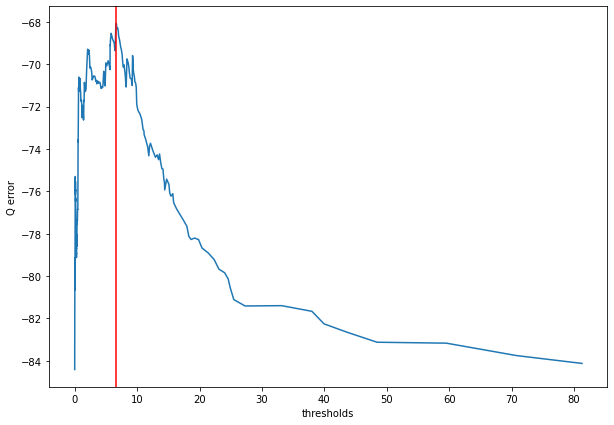

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(thresholds, variances)
plt.xlabel("thresholds")
plt.ylabel("Q error")
plt.axvline(x = threshold_best, color = "red")
plt.show()

In [ ]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "nonterminal": # если узел не терминальный, то идем до листьев
            if self._feature_types[node["feature_split"]] == "real": # проверяем принадлежность объекта для вещетвенных признаков
                if x[node["feature_split"]] < node["threshold"]:
                    return self._predict_node(x, node["left_child"])
                else:    
                    return self._predict_node(x, node["right_child"])
            else: 
                if x[node["feature_split"]] == node["category_split"]:# проверяем принадлежность объекта для категориальных признаков
                    return self._predict_node(x, node["left_child"])
                else:    
                    return self._predict_node(x, node["right_child"])
        else:
            return node["class"]

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

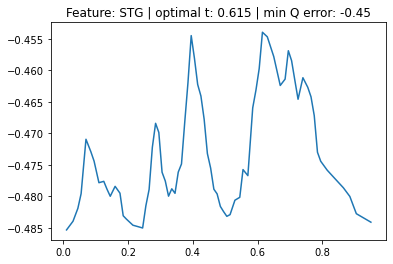

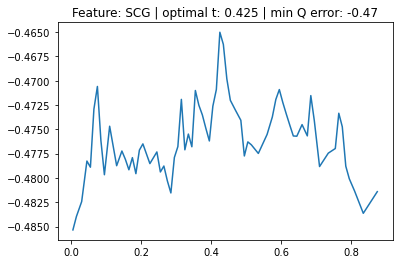

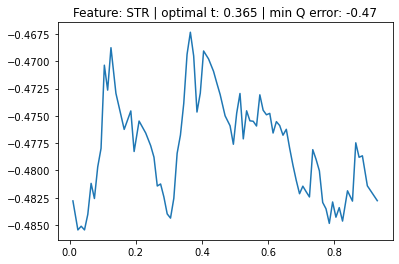

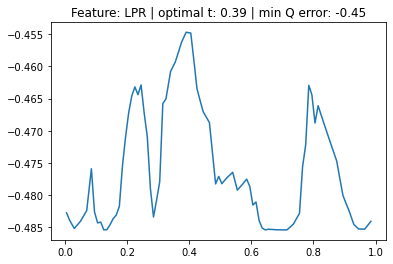

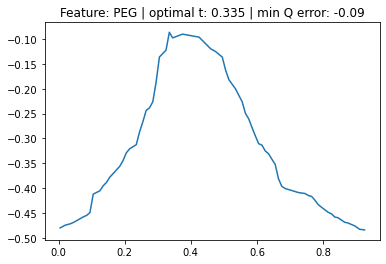

In [ ]:
data = pd.read_csv('students.csv')
y = data[" UNS"]
X = data.drop([" UNS"], axis = 1)

for f in X.columns:
    thresholds, variances, threshold_best, variance_best = find_best_split(X[f].to_numpy(), y, task="classification", feature_type="real")
    plt.figure()
    plt.title("Feature: {} | optimal t: {} | min Q error: {:.2f}".format(f, threshold_best, variance_best))
    plt.plot(thresholds, variances)
    plt.show()

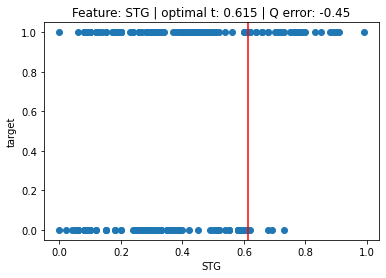

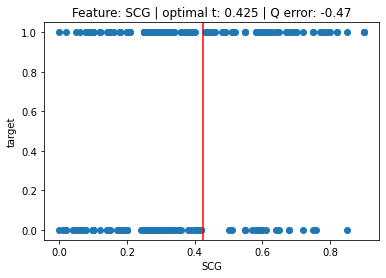

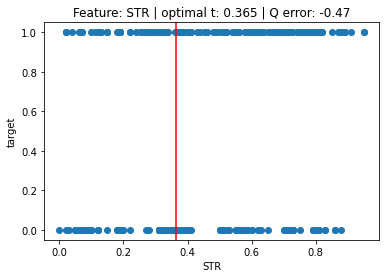

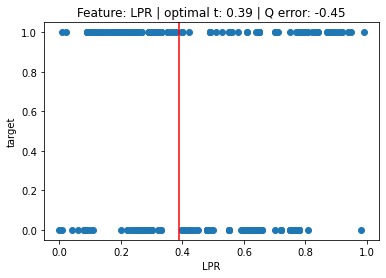

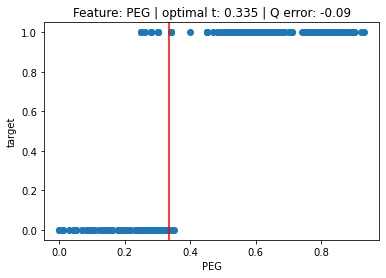

In [ ]:
for f in X.columns:
    _, _, threshold_best, variance_best = find_best_split(X[f].to_numpy(), y, task="classification", feature_type="real")
    plt.scatter(X[f], y)
    plt.axvline(x=threshold_best, color="red")
    plt.xlabel(f)
    plt.ylabel("target")
    plt.title("Feature: {} | optimal t: {} | Q error: {:.2f}".format(f, threshold_best, variance_best))
    plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = pd.read_csv('agaricus-lepiota.data', header=None)

le = LabelEncoder()
data = data.apply(lambda x: le.fit_transform(x), axis=0)

X = np.array(data.iloc[:, 1:])
y = np.array(data[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True)

cls = DecisionTree(["real"]*22,  min_samples_split=6, min_samples_leaf=4)
cls.fit(X_train, y_train)
print("Accuracy на тестовой выборке:", accuracy_score(y_test, cls.predict(np.array(X_test))))

Accuracy на тестовой выборке: 1.0


## бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

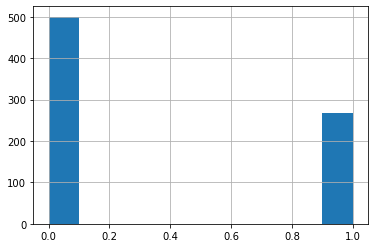

In [ ]:
data['Outcome'].hist()
plt.show()

In [ ]:
X = data.drop(['Outcome'], axis = 1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [ ]:
base_tree = DecisionTreeClassifier(random_state = 123)

bagging = BaggingClassifier(base_tree, n_estimators=50)
bagging.fit(X_train, y_train)

print('Accuracy test:', accuracy_score(y_test, bagging.predict(X_test)))
print('Precision test:', precision_score(y_test, bagging.predict(X_test)))
print('Recall test:', recall_score(y_test, bagging.predict(X_test)))
print('Auc_roc test:', roc_auc_score(y_test, bagging.predict(X_test)))

Accuracy test: 0.7619047619047619
Precision test: 0.7464788732394366
Recall test: 0.5888888888888889
Auc_roc test: 0.730614657210402


In [ ]:
rf = RandomForestClassifier(n_estimators=50)

rf.fit(X_train, y_train)

print('Accuracy test:', accuracy_score(y_test, rf.predict(X_test)))
print('Precision test:', precision_score(y_test, rf.predict(X_test)))
print('Recall test:', recall_score(y_test, rf.predict(X_test)))
print('Auc_roc test:', roc_auc_score(y_test, rf.predict(X_test)))

Accuracy test: 0.7792207792207793
Precision test: 0.8095238095238095
Recall test: 0.5666666666666667
Auc_roc test: 0.7407801418439717


Random forest работает лучше чем Bagging  каждый параметр при этом больше у первого, чем у второго. 

In [ ]:
import seaborn as sns
n_estimators = [50,100,133,200,272,467,493,504,784,1205]
min_samples_leaf = [2, 4, 7, 9, 10]

auc_roc = [] 
for n in n_estimators:
    for min in min_samples_leaf:
        rf = RandomForestClassifier(n_estimators=n, min_samples_leaf=min)
        rf.fit(X_train, y_train)
        auc_roc.append(roc_auc_score(y_test, rf.predict(X_test)))

<AxesSubplot:>

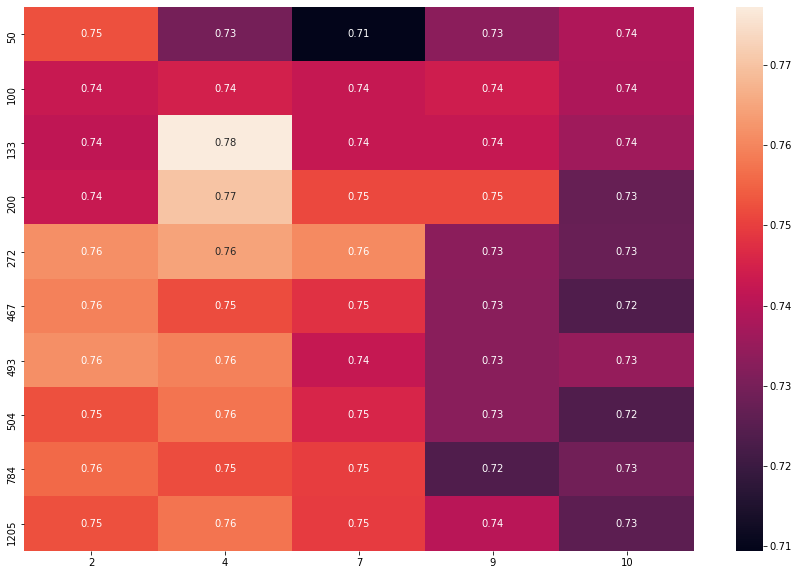

In [ ]:
sap = pd.DataFrame(np.array(auc_roc).reshape(10,5), index = n_estimators, columns = min_samples_leaf)

plt.figure(figsize=(15,10))
sns.heatmap(sap, annot=True)

[0.07230531 0.37757504 0.04970988 0.04843023 0.05621305 0.17527899
 0.07866484 0.14182266]


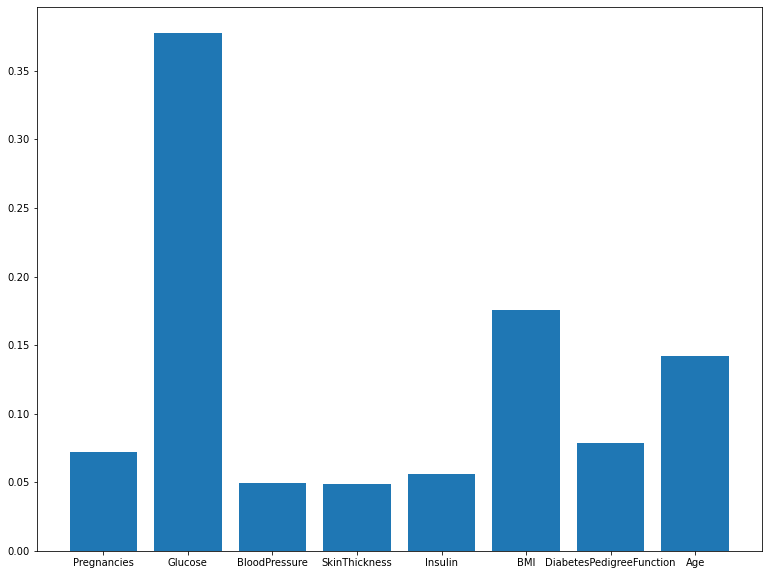

In [ ]:
plt.figure(figsize = (13, 10))
plt.bar(X.columns, rf.feature_importances_);
print(rf.feature_importances_)

Наиболее важным признаком оказалось количество глюкозы 